## Tensflow 

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(42)

In [2]:
tf.random.set_seed(42)

In [3]:
artists = pd.read_csv('data/artists.csv')
artists.shape

(50, 8)

In [4]:
artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [5]:
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
#artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [6]:
images_dir = 'data/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

In [7]:
# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3181 images belonging to 11 classes.
Found 790 images belonging to 11 classes.
Total number of batches = 198 and 49


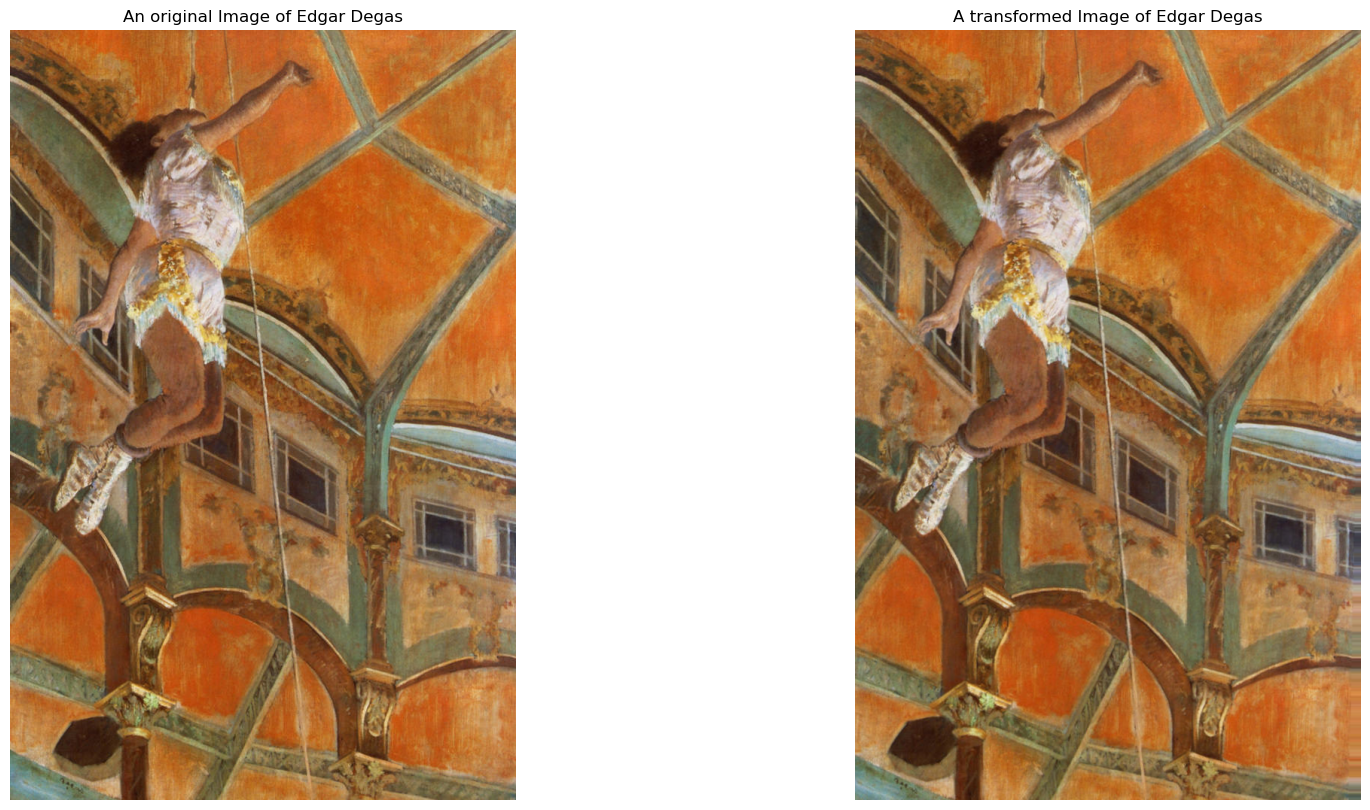

In [8]:
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

In [9]:
# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

In [10]:
for layer in base_model.layers:
    layer.trainable = True

In [11]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [12]:
model_eff=EfficientNetB2(weights='imagenet', include_top=False, input_shape=train_input_shape
)

In [13]:
for layer in model_eff.layers:
    layer.trainable = True

In [14]:
model_eff.summary()

Model: "efficientnetb2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

In [15]:
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model_res = Model(inputs=base_model.input, outputs=output)


In [16]:
X = model_eff.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)
model_eff = Model(inputs=model_eff.input, outputs=output)

In [17]:
optimizer = Adam(learning_rate=0.0001)
model_res.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [18]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [19]:
class_weights = artists_top['class_weight'].to_dict()

In [20]:
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

In [21]:
from tensorflow.python.distribute.collective_all_reduce_strategy import CollectiveAllReduceExtended
CollectiveAllReduceExtended._enable_check_health = False

In [22]:
class MyRunConfig(tf.estimator.RunConfig):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __deepcopy__(self, memo={}):
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            if '_distribute' in k:
                setattr(result, k, v)
            else:
                setattr(result, k, deepcopy(v, memo))
        return result

class MyDistributeStrategy(tf.distribute.MultiWorkerMirroredStrategy):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __deepcopy__(self, memo={}):
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            if '_extend' in k:
                setattr(result, k, v)
            else:
                setattr(result, k, deepcopy(v, memo))
        return result

In [23]:
strategy = MyDistributeStrategy()
config = MyRunConfig(train_distribute=strategy)

INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO
INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.


In [27]:
history1 = model_res.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                            validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                            epochs=n_epoch,
                            shuffle=True,
                            verbose=1,
                            callbacks=[reduce_lr],
                            use_multiprocessing=True,
                            workers=16,
                            class_weight=class_weights
                            )

Epoch 1/10


Exception in thread Thread-58:
Traceback (most recent call last):
  File "c:\Users\nikla\anaconda3\envs\NLP\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "c:\Users\nikla\anaconda3\envs\NLP\lib\threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\nikla\anaconda3\envs\NLP\lib\site-packages\keras\utils\data_utils.py", line 759, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "c:\Users\nikla\anaconda3\envs\NLP\lib\site-packages\keras\utils\data_utils.py", line 736, in pool_fn
    pool = get_pool_class(True)(
  File "c:\Users\nikla\anaconda3\envs\NLP\lib\multiprocessing\context.py", line 119, in Pool
    return Pool(processes, initializer, initargs, maxtasksperchild,
  File "c:\Users\nikla\anaconda3\envs\NLP\lib\multiprocessing\pool.py", line 212, in __init__
    self._repopulate_pool()
  File "c:\Users\nikla\anaconda3\envs\NLP\lib\multiprocessing\pool.py", line 303, in _repopulate_pool
    

In [ ]:
for layer in model_res.layers:
    layer.trainable = False

for layer in model_res.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model_res.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 10
history2 = model_res.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

NameError: name 'model_res' is not defined

In [ ]:
optimizer = Adam(lr=0.0001)
model_eff.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [ ]:
setattr(tf.contrib.rnn.GRUCell, '__deepcopy__', lambda self, _: self)
setattr(tf.contrib.rnn.BasicLSTMCell, '__deepcopy__', lambda self, _: self)
setattr(tf.contrib.rnn.MultiRNNCell, '__deepcopy__', lambda self, _: self)

AttributeError: module 'tensorflow' has no attribute 'contrib'

In [ ]:
n_epoch = 10
history1_eff = model_eff.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

Epoch 1/10


Exception in thread Thread-35:
Traceback (most recent call last):
  File "/Users/niclascramer/opt/miniconda3/envs/tensorflow/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Users/niclascramer/opt/miniconda3/envs/tensorflow/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/niclascramer/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/data_utils.py", line 781, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "/Users/niclascramer/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/data_utils.py", line 756, in pool_fn
    pool = get_pool_class(True)(
  File "/Users/niclascramer/opt/miniconda3/envs/tensorflow/lib/python3.9/multiprocessing/context.py", line 119, in Pool
    return Pool(processes, initializer, initargs, maxtasksperchild,
  File "/Users/niclascramer/opt/miniconda3/envs/tensorflow/lib/python3.9/multiprocessing/pool

In [ ]:
for layer in model_eff.layers:
    layer.trainable = False

for layer in model_eff.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model_eff.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 50
history2_eff = model_eff.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

In [ ]:
# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['acc'] = history1.history['acc'] + history2.history['acc']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_acc'] = history1.history['val_acc'] + history2.history['val_acc']
history['lr'] = history1.history['lr'] + history2.history['lr']

In [ ]:
# Merge history1 and history2
history_eff = {}
history_eff['loss'] = history1_eff.history['loss'] + history2_eff.history['loss']
history_eff['acc'] = history1_eff.history['acc'] + history2_eff.history['acc']
history_eff['val_loss'] = history1_eff.history['val_loss'] + history2_eff.history['val_loss']
history_eff['val_acc'] = history1_eff.history['val_acc'] + history2_eff.history['val_acc']
history_eff['lr'] = history1_eff.history['lr'] + history2_eff.history['lr']

In [ ]:
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    


In [ ]:
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    


In [ ]:
plot_training(history)

In [ ]:
plot_training(history_eff)

In [ ]:
# Prediction accuracy on train data
score = model_res.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

In [ ]:
score_eff = model_eff.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score_eff[1])

In [ ]:
url = 'https://www.gpsmycity.com/img/gd/2081.jpg'

import imageio
import cv2

web_image = imageio.imread(url)
web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
web_image = image.img_to_array(web_image)
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)


prediction = model_res.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()

In [ ]:
url = 'https://www.gpsmycity.com/img/gd/2081.jpg'

import imageio
import cv2

web_image = imageio.imread(url)
web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
web_image = image.img_to_array(web_image)
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)


prediction = model_eff.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()